# Ejercicio 2

Para esta seccion, seleccionamos de nuevo el corpus **cess_es** y lo preprocesamos de la misma manera que en el ejercicio 1

In [1]:
import re
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math   

from preprocesador import *
from subword import *
from frecuencias import *

os.environ["NLTK_DATA"]="datos_nltk/"
import  nltk
from nltk.corpus import stopwords

## Paso 1
Preprocesamos el corpus

In [2]:
## Seleccionamos el corpus
from nltk.corpus import cess_esp

nltk.download("cess_esp")

## Obtenemos las oraciones del corpus para el entrenamiento de nuestra red neuronal
corpus_sents = cess_esp.sents()[0:1000]

print("Numero de oraciones en el corpus:", len(corpus_sents))

[nltk_data] Downloading package cess_esp to /home/joel/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


Numero de oraciones en el corpus: 1000


In [3]:
# Procedemos a normalizar el texto:
nltk.download('stopwords')
stopwords_list = stopwords.words('spanish')

# Normalizamos los oraciones
sents_norm = [pre_procesar(oracion, stopwords_list) for oracion in corpus_sents]
# Obtenemos todas las palabras del texto
tokens_normalizados = [x for xs in sents_norm for x in xs]

print("Numero de tokens, despues del preprocesamiento:", len(tokens_normalizados))

[nltk_data] Downloading package stopwords to /home/joel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Numero de tokens, despues del preprocesamiento: 17801


In [4]:
# Entrenamos nuestro algoritmo de BPE con las palabras del corpus, 
# obtenemos las reglas y las frecuencias de cada token
freqs_bpe, reglas_bpe = entrenar_byte_pair_encoding(tokens_normalizados, 500)

In [5]:
# Aplicamos nuestro modelo bpe a cada oracion para obtener las oraciones tokenizadas
sents_tokenizadas = [aplicar_bpe(sent, reglas_bpe) for sent in sents_norm]

# Agregamos la etiqueta <BOS> a cada oracion
sents_tokenizadas = [["<BOS>"] + sent for sent in sents_tokenizadas]


In [6]:
# Construimos la tabla para las frecuencias de las palabras
tabla_frecuencias_bpe = crear_tabla_frecuencias(freqs_bpe)
print(tabla_frecuencias_bpe)

         palabra  frecuencia
0             de         523
1              a         432
2              o         429
3             to         334
4             do         289
...          ...         ...
4226   lazarocar           1
4227  realidades           1
4228       queri           1
4229       fatal           1
4230       pleta           1

[4231 rows x 2 columns]


In [7]:
#Convertimos la tabla en un diccionario para usarlo en el modelo
palabras = tabla_frecuencias_bpe['palabra']
frecuencias = tabla_frecuencias_bpe['frecuencia']
dic_palabras = {}  
for i in range(len(frecuencias)):
    dic_palabras[palabras[i]] = frecuencias[i]
dic_palabras["<BOS>"] = len(sents_norm)
dic_palabras["<EOS>"] = len(sents_norm)

In [8]:
ETIQUETA_UNK = "<UNK>"
def indices_palabras(palabras_frecuencias: dict):
    """Calcula los indices de las palabras dadas sus frecuencias

    Parameters
    ----------
    palabras_frecuencias : dict
        Diccionario donde las llaves son las palabras y los valores sus frecuencias

    Returns
    -------
    dict,dict
        Diccionarios uno a uno de palabras a indices y viceversa
    """
    result = {}
    for ind, palabra in enumerate(palabras_frecuencias.keys()):
        # Ocurrio un Happax legomena o singleton
        if palabras_frecuencias[palabra] == 1:
            # Indice temporal para UNK
            result[ETIQUETA_UNK] = len(palabras_frecuencias)
        else:
            result[palabra] = ind

    return {word: idx for idx, word in enumerate(result.keys())}, {idx: word for idx, word in enumerate(result.keys())}

In [9]:
#Se obtienen los índices de cada palabra
palabras_a_indices, indices_a_palabras = indices_palabras(dic_palabras)
print(palabras_a_indices)
print(indices_a_palabras)
len(palabras_a_indices)

{'de': 0, 'a': 1, 'o': 2, 'to': 3, 'do': 4, 'co': 5, 'con': 6, 're': 7, 'ta': 8, 'c': 9, 'i': 10, 'ca': 11, 'ti': 12, 'te': 13, 'e': 14, 'en': 15, 'al': 16, 'es': 17, 'cia': 18, 'l': 19, 'fi': 20, 'da': 21, 'si': 22, 'di': 23, 'ex': 24, 'd': 25, 'mo': 26, 'z': 27, 'pe': 28, 's': 29, 'li': 30, 'h': 31, '2': 32, 'os': 33, 'hoy': 34, 'f': 35, '1': 36, 'se': 37, 'on': 38, 't': 39, 'p': 40, 'g': 41, 'le': 42, 'pro': 43, 'ci': 44, 'dos': 45, 'k': 46, 'gi': 47, 'ra': 48, 'bi': 49, 'in': 50, 'tar': 51, 'mi': 52, 'que': 53, 'r': 54, 'pi': 55, 'ar': 56, 'ri': 57, 'gobierno': 58, 'vi': 59, 'su': 60, '4': 61, 'y': 62, 'presidente': 63, 'ce': 64, '6': 65, 'car': 66, 'tas': 67, 'an': 68, 'b': 69, 'des': 70, 'tos': 71, 'go': 72, 'por': 73, '3': 74, 'hi': 75, 'u': 76, 'as': 77, 'com': 78, 'tes': 79, 'er': 80, 'ro': 81, 'dad': 82, 'ter': 83, 'la': 84, 'fe': 85, 'ento': 86, 'vo': 87, '7': 88, 've': 89, '0': 90, 'no': 91, 'ni': 92, 'cion': 93, 'zo': 94, 'cu': 95, 'so': 96, 'me': 97, 'ver': 98, 'per': 99,

2593

In [10]:
def get_id(palabra_a_id: dict, palabra: str) -> int:
    """Obtiene el id de una palabra dada

    Si no se encuentra la palabra se regresa el id
    del token UNK

    Parameters
    ----------
    palabra_a_id : dict
        Diccionario de palabras a indices
    palabra : str
        Palabra a buscar

    Returns
    -------
    int
        Indice de la palabra
    """
    id_unknow = palabra_a_id[ETIQUETA_UNK]
    return palabra_a_id.get(palabra, id_unknow)

In [11]:
def lista_indices(corpus:list, palabras_a_indices:dict) -> list:
    """Genera una lista de indices que representan las palabras de un corpus 
    Parameters
    ----------
    corpus : list
        corpus a procesar
    indices_a_palabras : dict
        Diccionario de palabras a indices
    Returns
    -------
    list
        Lista de indices que representan las palabras del corpus
    """
    indices = []
    for sent in corpus:
        renglon = []
        for token in sent:
            renglon.append(get_id(palabras_a_indices, token))
        indices.append(renglon)
    return indices

In [12]:
def lista_siguientes(entradas : list) -> list:
    """
    Genera una lista de palabras siguientes a partir de una lista de palabras.
    Parameters
    ----------
    entradas : list
        lista de listas de palabras, donde cada lista tiene 
        como primer elemento la etiqueta <BOS>.
    Returns
    -------
    list
        Lista de listas donde cada palabra es la palabra que le sigue 
        en la entrada, o la etiqueta <EOS> si es la última de la lista.
    """
    salidas = []
    for sent in entradas:
        renglon = []
        for i in range(len(sent)-1):
            renglon.append(sent[i+1])    
        renglon.append("<EOS>")                
        salidas.append(renglon)
    return(salidas)

In [13]:
#Obtenemos los índices de cada oración
indices_sents = lista_indices(sents_tokenizadas, palabras_a_indices)
print(indices_sents[0])
print(sents_tokenizadas[0])

[2591, 270, 17, 1437, 919, 175, 44, 13, 0, 191, 64, 14, 25, 35, 519, 34, 159, 241, 78, 970, 117, 36, 147, 293, 742, 336, 919, 175, 44, 2590, 2590, 16, 801, 48, 14, 1, 1, 151, 737, 2338, 52, 39, 2339, 75, 249, 2340, 1475, 102, 145, 1216, 917, 61, 123, 117, 97, 129, 1650]
['<BOS>', 'grupo', 'es', 'tatal', 'elec', 'tri', 'ci', 'te', 'de', 'fran', 'ce', 'e', 'd', 'f', 'anuncio', 'hoy', 'jue', 'ves', 'com', 'pra', '5', '1', 'porciento', 'empresa', 'mexi', 'cana', 'elec', 'tri', 'ci', 'dadagui', 'lade', 'al', 'tami', 'ra', 'e', 'a', 'a', 'cre', 'ada', 'japones', 'mi', 't', 'subis', 'hi', 'cor', 'poration', 'poneren', 'mar', 'cha', 'central', 'gas', '4', '9', '5', 'me', 'ga', 'vatios']


In [14]:
#Obtenemos las palabras siguientes y sus índices
siguientes_tokenizadas = lista_siguientes(sents_tokenizadas)
indices_siguientes = lista_indices(siguientes_tokenizadas, palabras_a_indices)

print(siguientes_tokenizadas[0])
print(indices_siguientes[0])

['grupo', 'es', 'tatal', 'elec', 'tri', 'ci', 'te', 'de', 'fran', 'ce', 'e', 'd', 'f', 'anuncio', 'hoy', 'jue', 'ves', 'com', 'pra', '5', '1', 'porciento', 'empresa', 'mexi', 'cana', 'elec', 'tri', 'ci', 'dadagui', 'lade', 'al', 'tami', 'ra', 'e', 'a', 'a', 'cre', 'ada', 'japones', 'mi', 't', 'subis', 'hi', 'cor', 'poration', 'poneren', 'mar', 'cha', 'central', 'gas', '4', '9', '5', 'me', 'ga', 'vatios', '<EOS>']
[270, 17, 1437, 919, 175, 44, 13, 0, 191, 64, 14, 25, 35, 519, 34, 159, 241, 78, 970, 117, 36, 147, 293, 742, 336, 919, 175, 44, 2590, 2590, 16, 801, 48, 14, 1, 1, 151, 737, 2338, 52, 39, 2339, 75, 249, 2340, 1475, 102, 145, 1216, 917, 61, 123, 117, 97, 129, 1650, 2592]


## Paso 2 
Construimos la red neuronal recurrente 

In [15]:
import torch    
import torch.nn as nn

In [16]:
class RecurrentNetwork(nn.Module):
    def __init__(self, dim_in, dim_out, dim=100, dim_h=200):
        super().__init__()
        #Capa de embedding
        self.emb = nn.Embedding(dim_in,dim)
        #Capa de RNN (bidireccional)
        self.recurrence = nn.RNN(dim, dim_h, bidirectional=True)
        #Capa lineal
        lineal = nn.Linear(2*dim_h,dim_out)
        #Activacion
        pre = nn.Softmax(dim=2)
        #Salida
        self.ffw = nn.Sequential(lineal, pre)
        
    def forward(self, x):
        #Se convierte en tensor
        x = torch.tensor(x)
        #Embedding
        x = self.emb(x)
        x = x.unsqueeze(1)
        #Capas recurrentes
        h, c = self.recurrence(x)
        #Activación
        h = h.tanh()
        #Salida
        y_pred = self.ffw(h)
        y_pred = y_pred.transpose(1, 2)
        return y_pred

    def get_emb(self):
        return self.emb

In [17]:
#Se crea la red recurrente
#Numero de iteraciones
EPOCHS = 10
#Taza de aprendizaje
LEARNING_RATE = 0.02
#Dimension
dim = 2

#Se crea la red
rnn = RecurrentNetwork(len(indices_a_palabras.keys()), len(indices_a_palabras.keys()))

#Se definen los conjuntos de entradas y salidas
x = indices_sents
y = indices_siguientes

#Se define la función de riesgo y el optimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(rnn.parameters(), LEARNING_RATE)

In [18]:
 #Se entrena el modelo
for epoch in range(EPOCHS):
    for x_i, y_i in zip(x, y):
        #Forward
        y_pred = rnn(x_i)

        #Backward
        y_i = (torch.tensor(y_i)).unsqueeze(1)

        #Se calcula el eror
        loss = criterion(y_pred, y_i)

        #zero grad
        optimizer.zero_grad()
        #Backprop
        loss.backward()
        #Actualizar parametros
        optimizer.step()

    print(f"Epoch={epoch}. Training loss={loss}")


Epoch=0. Training loss=7.787030220031738
Epoch=1. Training loss=7.750726699829102
Epoch=2. Training loss=7.749993324279785
Epoch=3. Training loss=7.749973297119141
Epoch=4. Training loss=7.749995708465576
Epoch=5. Training loss=7.71314001083374
Epoch=6. Training loss=7.712960720062256
Epoch=7. Training loss=7.71293306350708
Epoch=8. Training loss=7.712952136993408
Epoch=9. Training loss=7.712929725646973


In [19]:
def get_valor(tupla):
    return tupla[1]

def get_proba(corpus_eval : list, palabras_a_ind : dict, sort_func) -> list:
    probas = []
    ind_corpus = [palabras_a_ind[w] for w in corpus_eval]
    output = rnn(ind_corpus)
    for i in range(len(corpus_eval)):
        renglon = []
        for j in range(len(palabras_a_ind.keys())):
            palabras = list(palabras_a_ind.keys())
            valor = output[i][j].item()
            renglon.append((palabras[j], valor, j))
        renglon.sort(key=sort_func, reverse=True)
        probas.append(renglon)
    return probas


In [20]:
prueba = ["<BOS>", "grupo", "es", "tatal", "<EOS>"]
probas = get_proba(prueba, palabras_a_indices, get_valor)
for p in range(len(probas)):
    print(f"Probas para {prueba[p]}")
    for proba in probas[p][0:10]:
        print(proba)
    print("")

Probas para <BOS>
('en', 0.40815067291259766, 15)
('te', 0.2054554671049118, 13)
('re', 0.12209904938936234, 7)
('<EOS>', 0.08431662619113922, 2592)
('si', 0.0766080990433693, 22)
('di', 0.026075780391693115, 23)
('tri', 0.02585514634847641, 175)
('de', 0.021285708993673325, 0)
('<UNK>', 0.013227386400103569, 2590)
('do', 0.004608694929629564, 4)

Probas para grupo
('ci', 0.3443736135959625, 44)
('do', 0.17386336624622345, 4)
('en', 0.1214723140001297, 15)
('de', 0.07537972182035446, 0)
('di', 0.05935594439506531, 23)
('e', 0.05603150650858879, 14)
('tivo', 0.05084279924631119, 161)
('re', 0.03729741647839546, 7)
('si', 0.036166585981845856, 22)
('co', 0.012685783207416534, 5)

Probas para es
('do', 0.8204184770584106, 4)
('<UNK>', 0.038050368428230286, 2590)
('re', 0.030106520280241966, 7)
('to', 0.022988367825746536, 3)
('te', 0.01840873248875141, 13)
('di', 0.015399094671010971, 23)
('con', 0.011461601592600346, 6)
('hoy', 0.007868628948926926, 34)
('c', 0.00601130910217762, 9)
('i'

In [21]:
#Perplejidad
def get_perplexity(corpus_eval : list, palabras_a_ind : dict) -> float:
    perplexity = 0
    indices_corpus = []
    for token in corpus_eval:
        if token in palabras_a_ind.keys():
            indices_corpus.append(palabras_a_ind[token])
        else:
            indices_corpus.append(palabras_a_ind["<UNK>"])
            
    output = rnn(indices_corpus)
    probas = []
    for i in range(len(output)-1):
        probas.append(output[i][indices_corpus[i+1]].item())

    for p in probas:
        if(perplexity != 0):
            perplexity != 1/p
        else:
            perplexity = 1/p
    return perplexity ** (1/(len(corpus_eval)-2))

In [22]:
#Probando la perplejidad con tokens del corpus
evaluacion = ["<BOS>", "grupo", "es", "tatal", "<EOS>"]
perplejidad = get_perplexity(evaluacion, palabras_a_indices)
print(f"Perplejidad de la oración: {perplejidad}")

Perplejidad de la oración: 117.60486451602513


In [23]:
#Probando la perplejidad con tokens en desorden
evaluacion = ["<EOS>", "es", "grupo", "tatal", "<BOS>"]
perplejidad = get_perplexity(evaluacion, palabras_a_indices)
print(f"Perplejidad de la oración: {perplejidad}")

Perplejidad de la oración: 5.1807825851267


In [24]:
import random
def generate_words(palabras_a_ind: dict, longitud: int) -> str:
    oracion = ""
    ultima = "<BOS>"
    for i in range(longitud):
        result = get_proba([ultima], palabras_a_ind, get_valor)
        siguiente = "<UNK>"
        ind = random.randint(0, 10)
        while siguiente == "<UNK>": #Se vuelve a elegir si toca un UNK
            siguiente = result[0][ind][0]
            ind = random.randint(0, 10)
        if(siguiente == "<EOS>"):
            oracion += ". "
        elif(siguiente != "<BOS>"):
            oracion += f"{siguiente} "
        ultima = siguiente
    return oracion

In [25]:
#Generamos una oración
print("Generando oracion: ")
print(generate_words(palabras_a_indices, 10))

Generando oracion: 
ci ta hoy re te es di tri ti ra 


In [61]:
last_ind = len(list(indices_a_palabras.keys()))
last_emb = torch.tensor(list(range(last_ind)))

In [62]:
two_emb = []
for ind in indices_a_palabras.keys():
    emb_vector = rnn.emb(last_emb).detach().numpy()[ind]
    elem = [e for e in emb_vector[0:2]]
    two_emb.append(elem)

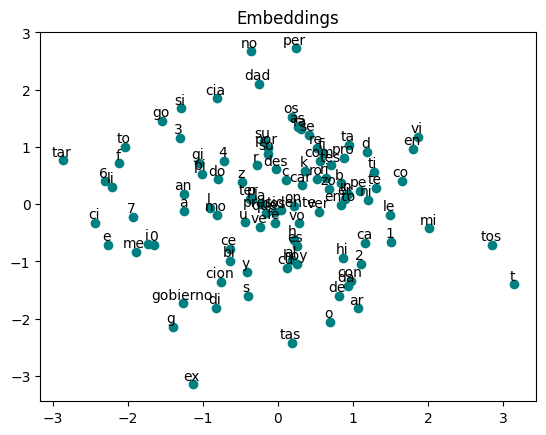

In [64]:
#Obteniendo los embeddings 2D
def plot_words(Z, ids):
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='teal')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1

plot_words(np.array(two_emb)[0:100], list(palabras_a_indices.keys()))
plt.title('Embeddings')
plt.show()